In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import \
        split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *

In [2]:
URM = createURM()
ICM = createSmallICM()

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\recsys2022DataReader.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [3]:
profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

In [5]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

In [6]:
from Recommenders.Hybrid.LinearHybridRecommender import LinearHybridTwoRecommenderTwoVariables
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.Implicit.ImplicitALSRecommender import ImplicitALSRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "RP3beta_ItemKNNCF_Hybrid": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "ImplicitALSRecommender": ImplicitALSRecommender,
                                   "SlimElasticNet": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    if(label == 'RP3beta_ItemKNNCF_Hybrid'):
        recommender1 = ItemKNNCFRecommender(URM_train, verbose=False)
        recommender1.fit(ICM=ICM*58, shrink=1665.2431108249625, topK=3228, similarity='dice', feature_weighting='bm25', normalization='bm25')
        recommender2 = RP3betaRecommender(URM_train, verbose=False)
        recommender2.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
        recommender_object = LinearHybridTwoRecommenderTwoVariables(URM_train=URM_train, Recommender_1=recommender1, Recommender_2=recommender2)
        recommender_object.fit(alpha=0.0456180823477569, beta=0.7890742999166246)

    elif(label == 'P3alpha'):
        recommender_object.fit(topK=218, alpha=0.8561168568686058)
    elif(label == 'RP3beta'):
        recommender_object.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
    elif(label == 'ImplicitALSRecommender'):
        recommender_object.fit(iterations=94, factors=287, alpha=10, regularization=0.01)
    elif(label == 'SlimElasticNet'):
        recommender_object.fit(topK=359, alpha=0.04183472018614359, l1_ratio=0.03260349571135893)
    else:
        recommender_object.fit()


    recommender_object_dict[label] = recommender_object

Done: 100%|██████████| 24507/24507 [00:04<00:00, 5147.26it/s]            


P3alphaRecommender: Similarity column 24507 (100.0%), 2368.65 column/sec. Elapsed time 10.35 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 2854.69 column/sec. Elapsed time 8.58 sec


  0%|          | 0/94 [00:00<?, ?it/s]

100%|█████████▉| 24504/24507 [11:03<00:00, 36.91it/s]


In [7]:
cutoff = 10
from Evaluation.Evaluator import EvaluatorHoldout
from Evaluation.Evaluator_IALS import EvaluatorHoldout as EIALS

list_group_interactions = [[0, 19] , [20, 39], [40, 69], [70, max(interactions)]]
for group_id in range(0, 4):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions)) if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print(f"Evaluating group: {group_id}")

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    evaluator_test_IALS = EIALS(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Evaluating group: 0
EvaluatorHoldout: Ignoring 961 ( 2.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 34127 Users
EvaluatorHoldout: Ignoring 34127 Users
EvaluatorHoldout: Processed 6919 (100.0%) in 5.21 sec. Users per second: 1328
EvaluatorHoldout: Processed 6919 (100.0%) in 8.98 sec. Users per second: 771
EvaluatorHoldout: Processed 6919 (100.0%) in 4.74 sec. Users per second: 1459
EvaluatorHoldout: Processed 6919 (100.0%) in 4.94 sec. Users per second: 1402
EvaluatorHoldout: Processed 6919 (100.0%) in 5.99 sec. Users per second: 1154
EvaluatorHoldout: Processed 6919 (100.0%) in 5.35 sec. Users per second: 1294
Evaluating group: 1
EvaluatorHoldout: Ignoring 961 ( 2.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 19381 Users
EvaluatorHoldout: Ignoring 19381 Users
EvaluatorHoldout: Processed 21872 (100.0%) in 14.65 sec. Users per second: 1493
EvaluatorHoldout: Processed 21872 (100.0%) in 28.66 sec. Users per second: 763
Evaluato

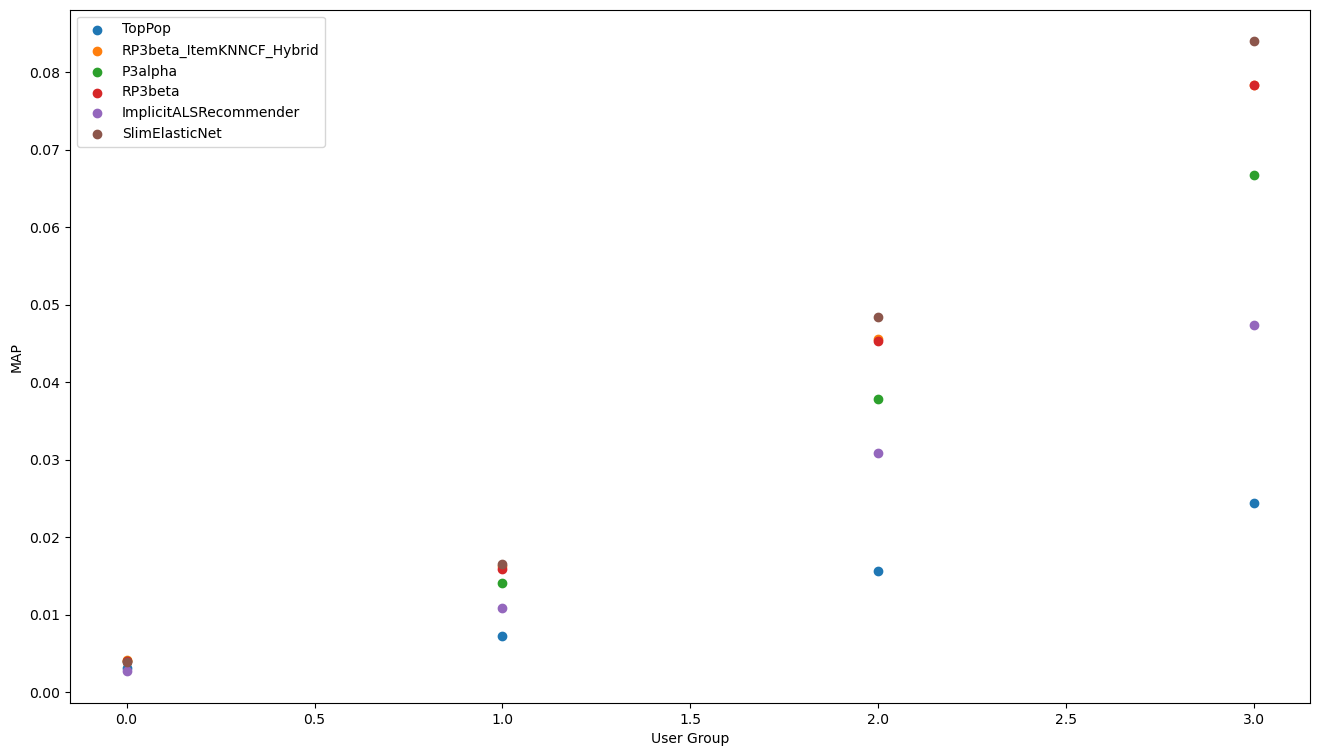

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()